<a href="https://colab.research.google.com/github/jsm-UOC/tensorflowCourse/blob/main/SkimLitNLPProjectANNCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: SkimLit

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 5.79 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-08 17:11:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-08 17:11:03 (88.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Preprocess data

In [ ]:
def get_lines(filename):

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["line_number"] = abstract_line_number
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"] = len(abstract_line_split) -1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 610 ms, sys: 112 ms, total: 722 ms
Wall time: 1.74 s


In [ ]:
train_samples[:25]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

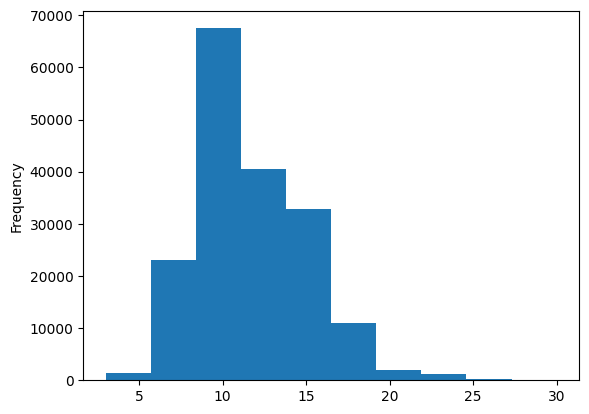

In [ ]:
train_df.total_lines.plot.hist();

### Get list of sentences

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Making numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Experiments and models

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len, np.median(sent_lens)

(26.338269273494777, 23.0)

(array([4.6220e+03, 2.0864e+04, 3.5052e+04, 3.6426e+04, 2.8882e+04,
        2.0006e+04, 1.2593e+04, 7.6670e+03, 4.8980e+03, 2.6580e+03,
        2.0780e+03, 1.3590e+03, 8.9500e+02, 6.0000e+02, 4.4400e+02,
        2.9300e+02, 2.0300e+02, 1.2500e+02, 1.0000e+02, 6.5000e+01,
        4.9000e+01, 3.6000e+01, 2.6000e+01, 2.3000e+01, 1.2000e+01,
        8.0000e+00, 1.1000e+01, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,   6.9,  12.8,  18.7,  24.6,  30.5,  36.4,  42.3,  48.2,
         54.1,  60. ,  65.9,  71.8,  77.7,  83.6,  89.5,  95.4, 101.3,
        107.2, 113.1, 119. , 124.9, 130.8, 136.7, 142.6, 148.5, 154.4,
        160.3, 166.2, 172.1, 178. , 183.9, 189.8, 195.7, 201.6, 207.5,
        213.4, 219.3, 225.2, 231.1

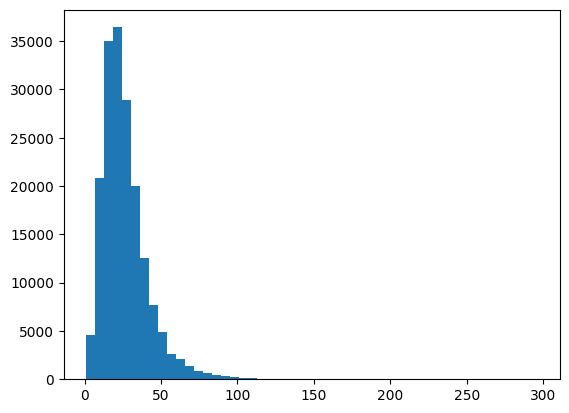

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len, max(sent_lens)

(55, 296)

### Text vectorization layer

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence)}")
print(f"\nVectorized text:{text_vectorizer(target_sentence)}")

Text:
the groups had similar clinical and echocardiographic baseline variables .

Length of text:74

Vectorized text:[   2   24   55  150   47    3 3880   49  498    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the groups had similar clinical and echocardiographic baseline variables .

Sentence after vectorization (before embedding):
[[   2   24   55  150   47    3 3880   49  498    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.04499475 -0.01326169 -0.03768411 ...  0.02507658 -0.02197056
   -0.02537351]
  [-0.0017521   0.04214941 -0.0220917  ... -0.01209352  0.04073871
   -0.03968849]
  [ 0.04637208 -0.00336567 -0.0168205  ...  0.03238075  0.04724152
   -0.01962835]
  ...
  [-0.03761232  0.01197278  0.04224502 ... -0.02707001  0.03219875
   -0.04987115]
  [-0.03761232  0.01197278  0.04224502 ... -0.02707001  0.03219875
   -0.04987115]
  [-0.03761232  0.01197278  0.04224502 ... -0.02707001  0.03219875
   -0.04987115]]]

Embedded sentence shape: 

## Creating Datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 61ms/step - loss: 0.9078 - accuracy: 0.6408 - val_loss: 0.6803 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6573 - accuracy: 0.7547 - val_loss: 0.6282 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6185 - accuracy: 0.7735 - val_loss: 0.5981 - val_accuracy: 0.7806


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5992 - accuracy: 0.7865


[0.5991873145103455, 0.7865086793899536]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.1779494e-01, 1.7474206e-01, 8.1960127e-02, 2.9433703e-01,
         3.1165773e-02],
        [4.5649102e-01, 2.6746550e-01, 1.4729268e-02, 2.5290868e-01,
         8.4054843e-03],
        [1.8508801e-01, 7.9336343e-03, 1.8627387e-03, 8.0507123e-01,
         4.4473101e-05],
        ...,
        [5.7173047e-06, 5.4334139e-04, 7.2819769e-04, 4.7918024e-06,
         9.9871802e-01],
        [5.7336506e-02, 4.3796009e-01, 1.1000175e-01, 7.6018922e-02,
         3.1868276e-01],
        [1.4704397e-01, 7.0119250e-01, 4.4989936e-02, 4.2260893e-02,
         6.4512663e-02]], dtype=float32),
 (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 78.65086720508407,
 'precision': 0.7834888196520907,
 'recall': 0.7865086720508407,
 'f1': 0.7839822321401206}

## Model 2: Feature Extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 current clinical trials nct@ , registered @ august , @ .
Sentence after embedding:
[[-0.04642477  0.02005388 -0.02157543 -0.06244771 -0.05411965  0.00270905
  -0.02330516 -0.02193247 -0.04082733 -0.08179746  0.07201044 -0.04427638
   0.00946895 -0.03750489  0.05549862  0.00887336 -0.08327484  0.00702344
  -0.00775694 -0.05541828 -0.03810001  0.04429635 -0.02689157 -0.03134048
  -0.03160239  0.02210712 -0.00645805  0.02649247 -0.06592619  0.00387072
  -0.02618414  0.08361664 -0.05223959  0.04598694  0.02639733 -0.05524084
  -0.07663642 -0.07439795 -0.03338347  0.01933994 -0.02611518  0.01770567
   0.0584393  -0.03844834  0.07328133  0.01046506 -0.01075649  0.06463549
  -0.04792278  0.03860833 -0.00892399 -0.04788261 -0.07396236  0.01811604
   0.00853697 -0.05573425  0.00866675 -0.05488843 -0.02251993  0.05783007
  -0.01597233  0.05034728  0.01056142 -0.00176954 -0.0137661   0.00630664
  -0.02026537 -0.01413164 -0.04890675  0.06563161 -0.00757724 -0.08498911
   0.059452


### Building and fitting an NLP feature extraction

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_2_USE_feature_extraction")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9177 - accuracy: 0.6516 - val_loss: 0.7998 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7708 - accuracy: 0.7000 - val_loss: 0.7589 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7557 - accuracy: 0.7111 - val_loss: 0.7444 - val_accuracy: 0.7045


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7456 - accuracy: 0.7114


[0.7455663681030273, 0.7114391922950745]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 16s 16ms/step


array([[4.1755757e-01, 3.9628184e-01, 2.0082770e-03, 1.7568558e-01,
        8.4667485e-03],
       [3.3473885e-01, 5.2238220e-01, 3.4140397e-03, 1.3668205e-01,
        2.7828487e-03],
       [2.0944972e-01, 1.5737873e-01, 1.8145207e-02, 5.6832343e-01,
        4.6702843e-02],
       ...,
       [1.7617242e-03, 6.3506323e-03, 5.2177612e-02, 9.0521533e-04,
        9.3880486e-01],
       [3.4095505e-03, 4.3906514e-02, 1.8577404e-01, 1.2716247e-03,
        7.6563823e-01],
       [2.0597884e-01, 2.7064550e-01, 4.6234512e-01, 6.7971935e-03,
        5.4233309e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.1439163246392,
 'precision': 0.7122883544563651,
 'recall': 0.7114391632463921,
 'f1': 0.7083512689711632}

In [ ]:
baseline_results, model_1_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 78.65086720508407,
  'precision': 0.7834888196520907,
  'recall': 0.7865086720508407,
  'f1': 0.7839822321401206})

## Model 3: Conv1D with character embeddings


### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

'c u r r e n t   c l i n i c a l   t r i a l s   n c t @   ,   r e g i s t e r e d   @   a u g u s t   ,   @   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

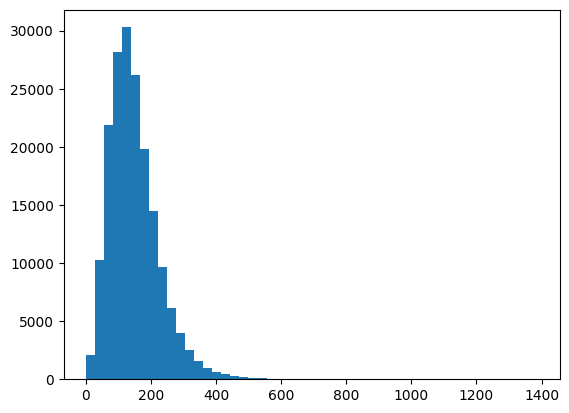

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=50);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 n o n e   o f   t h e   p a t i e n t s   f r o m   t h e   i n j e c t e d   g r o u p   a n d   @   f r o m   t h e   p l a c e b o   g r o u p   r e c e i v e d   @   m g   o f   k e t o p r o f e n   i n t r a v e n o u s l y   f o r   r e s c u e   a n a l g e s i a   i n   t h e   f i r s t   @   h o u r s   a f t e r   t h e   r e l e a s e   o f   t h e   t o u r n i q u e t   .

Length of random_train_chars: 389

Vectorized chars:
[[ 6  7  6  2  7 17  3 13  2 14  5  3  4  2  6  3  9 17  8  7 15  3 13  2
   4  6 27  2 11  3  2 10 18  8  7 16 14  5  6 10 17  8  7 15  3 13  2 14
  12  5 11  2 22  7 18  8  7 16 14  8  2 11  2  4 21  2 10 15 18  7 17 23
   2  3  7 14  8  7 17  2  6  4  6  3  8  5 21  2  6  7 16  9 12 19 17  7
   8  8  2  9 11 16  2  5  6  5 12 18  2  9  4  5  4  6  3 13  2 17  4  8
   9  3 13  7 16  8  9  5 17  3  2  8  3 13  2  8  2 12  2  5  9  2  7 17
   3 13  2  3  7 16  8  6  4 26 16  2  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  